# Pre-processing


In [1]:
import scipy.io as scio
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
import tqdm

## Get data - without baseline 
Removal method from Gniadecka

In [2]:
tissue3 = scio.loadmat('../Data/tissue3_1.mat')
tissue6 = scio.loadmat('../Data/tissue6.mat')
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

tissue_data = [tissue3,tissue6,tissue30,tissue31,tissue34_1,tissue34_2,tissue36,tissue37,tissue39_1]
file_names = ['map_t3_nobl.txt','map_t6_nobl.txt','map_t30_nobl.txt','map_t31_nobl.txt','map_t34_1_nobl.txt','map_t34_2_nobl.txt','map_t36_nobl.txt','map_t37_nobl.txt','map_t39_1_nobl.txt']

In [3]:
tissues = []
count = 0
for item in tissue_data: 
    t_IDX = item['IDX']
    t_bcc = item['bcc']
    width = t_bcc.shape[0]
    height = t_bcc.shape[1]
    t_map = np.loadtxt(file_names[count]).reshape(width*height,1024)
    tissues.append((t_map,t_bcc,t_IDX,width,height))
    count += 1
    
# tissues: (t_map, t_bcc, t_IDX, width, height)

In [4]:
## Train PCA only on relevant BCC data
pca_training_data = np.zeros((1000,1024))
count = 0

for tissue in tissues:
    for i in range(width):
        for j in range(height):
            if count < 1000:
                if tissue[1][i,j] == 1:
                    index = i*height + j
                    pca_training_data[count] = tissue[0][index,:]
                    count += 1

## PCA dimensionality reduction

In [5]:
# Fit PCA to data 
norm_data = normalize(pca_training_data)
pca = PCA(n_components=200)
pca.fit(norm_data)
pca_tissue = []

for i in range(len(tissues)):
    (t_map,t_bcc,t_IDX,width,height) = tissues[i]
    # Transform data with PCA
    transformed = pca.transform(t_map)
    pca_tissue.append((t_map,transformed,t_bcc,t_IDX,width,height))

# CNN

## Define network

In [13]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self,length):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1   = nn.Conv1d(1,5,kernel_size=3,padding='same')      # out: [batch, 5, 128]
        self.relu1   = nn.ReLU()                                         # out: [batch, 5, 128]
        self.pool1   = nn.AvgPool1d(3, stride=2, padding=1)              # out: [batch, 5, 64]  
        self.conv2   = nn.Conv1d(5,10,kernel_size=3,padding='same')     # out: [batch, 10, 64]

        self.flat    = nn.Flatten()                                      # out: [batch, 640]
        self.drop    = nn.Dropout(p=0.2)

        self.fc1     = nn.Linear(5*length, 2) # or 5?
        #self.relu2   = nn.ReLU()
        #self.fc2     = nn.Linear(50, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
    
        output = self.flat(output)
        output = self.drop(output) 

        output = self.fc1(output)
        #output = self.relu2(output)
        #output = self.fc2(output)
        output = self.softmax(output)
        return output

## Train

In [15]:
# PARAMETERS
learning_rate = 0.01
num_epochs    = 50
length        = 200

In [16]:
model = ConvolutionalNeuralNetwork(length)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 
model.train();

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


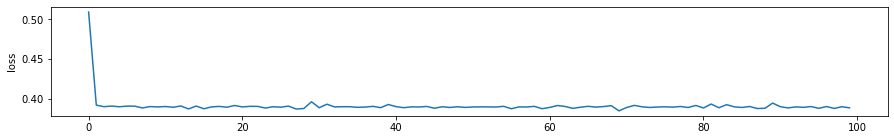

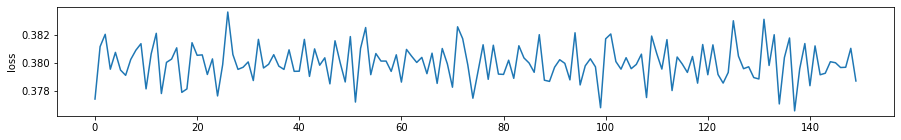

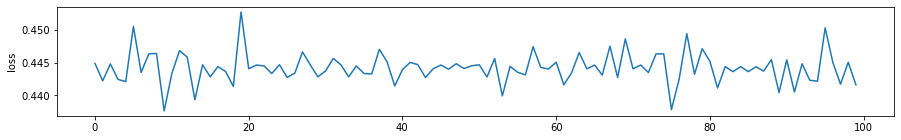

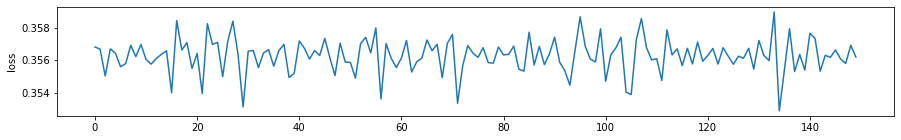

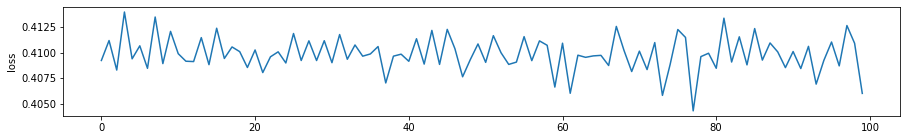

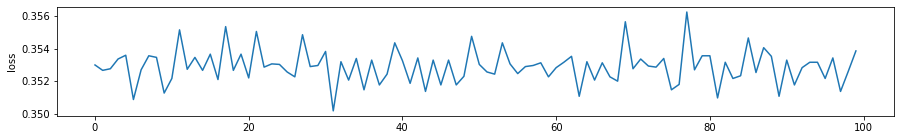

In [17]:
for (_,X,Y,_,w,h) in pca_tissue[0:6]:
        X = X.reshape(w*h,1,-1)
        Y = Y.reshape(w*h)
        
        tensor_X = torch.Tensor(X)
        tensor_Y = torch.Tensor(Y).long()
        dataset = torch.utils.data.TensorDataset(tensor_X, tensor_Y)

        data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
                sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=30000, drop_last=False))

        loss_history = []
        accuracy_history = []
        for epoch in tqdm.trange(num_epochs):
                for i, (inputs, targets) in enumerate(data_loader):
                        optimizer.zero_grad()
                        y_pred = model(inputs)
                        loss = criterion(y_pred, targets)
                        loss.backward()
                        optimizer.step()
                        loss_history.append(loss.item())
        plt.figure(figsize=(15,2))
        plt.plot(loss_history)
        plt.ylabel('loss')

## Evaluate

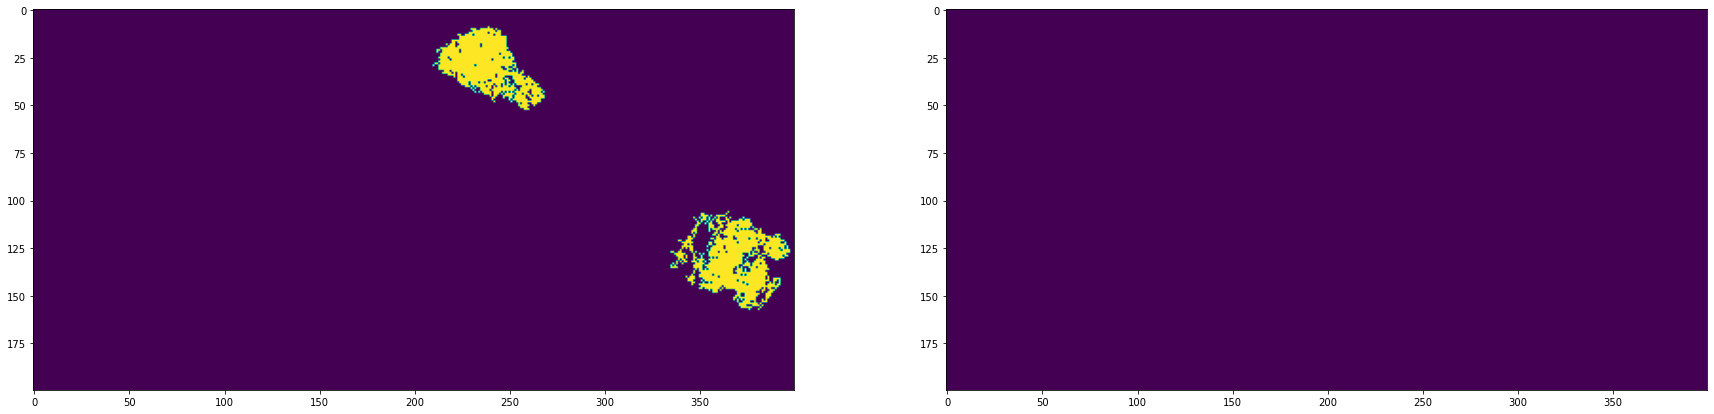

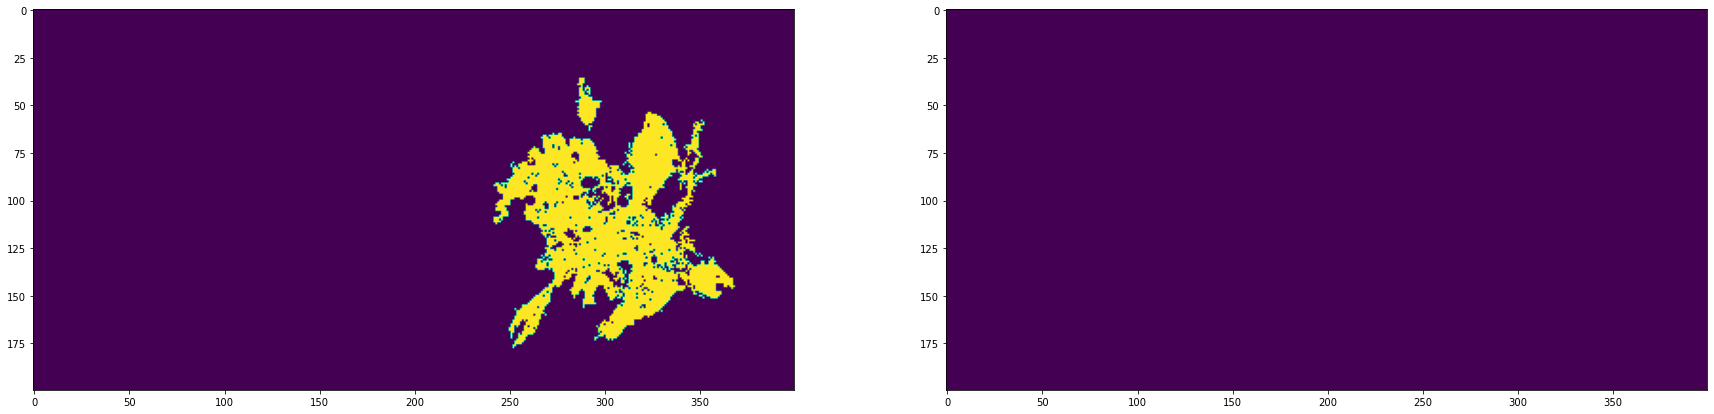

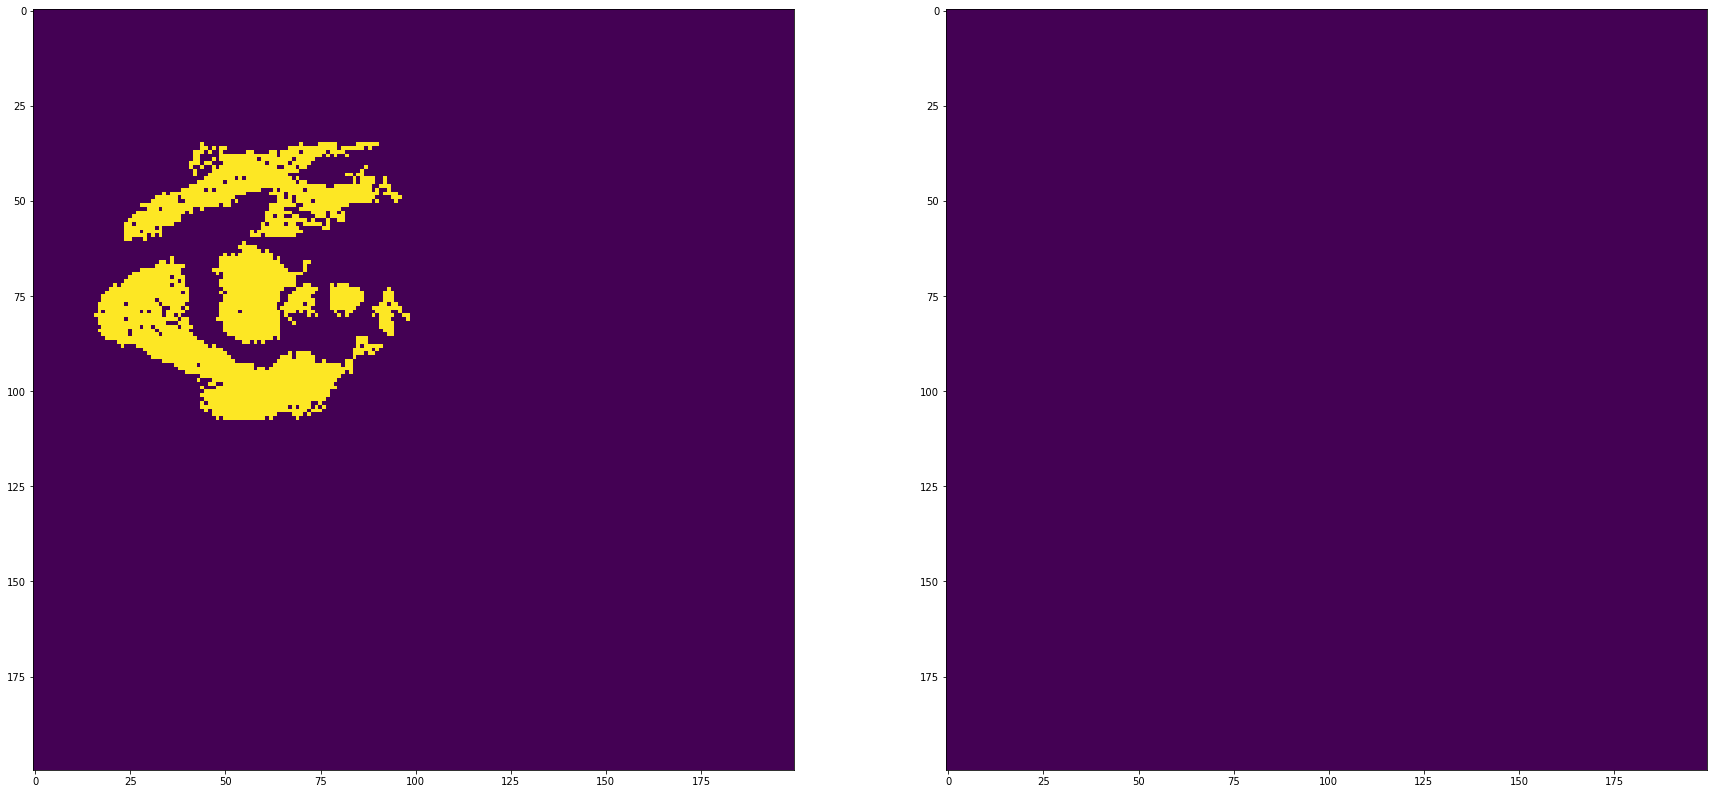

In [18]:
model.eval();

for (_,X,Y,_,w,h) in pca_tissue[6:]:
        X = X.reshape(w*h,1,-1)
        tensor_X = torch.Tensor(X)
        
        y_pred = model(tensor_X) 
        
        # Reshape 
        y_pred_long = []
        results = np.zeros((w,h))
        
        for item in y_pred:
            array = item.detach().numpy()
            index = np.argmax(array)
            y_pred_long.append(index)
        
        for i in range(w):
            for j in range(h):
                index = i*h + j
                results[i,j] = y_pred_long[index]
                
        # Plot results
        fig, axs = plt.subplots(1,2, figsize=(30,15))
        axs[0].imshow(Y)
        axs[1].imshow(results)